## Exercise 1

 - Import Barcelona_air_pollution data
 - Make a descriptive analysis to find the most interessting series to predict, for example you can answer your self if pollution levels are higher or lower during specific year seasons or parts of the day.
 - Train a LSTM NN and use the last 6 months history to validate (3 months) and test (3 months).
 - You can use weather data to improve your modelling and predictions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [3]:
air_pol = pd.read_csv('/content/drive/MyDrive/Ironhack/LSTM/Barcelona_air_pollution.csv', sep = ';')
air_pol['date_hour0'] = air_pol['date'] + ' ' + air_pol['hour'].astype(str)
air_pol['date_hour'] = pd.to_datetime(air_pol['date_hour0'], format = '%d/%m/%Y %H')
air_pol.drop(['date','hour','date_hour0'], axis = 1, inplace = True)
air_pol.tail(5)

,lon,lat,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,aqi,year,city,date_hour
17324,41.3888,2.159,216.96,0.0,0.07,40.05,0.05,2.71,5.42,0.37,1,2022,Barcelona,2022-12-31 20:00:00
17325,41.3888,2.159,216.96,0.0,0.07,38.98,0.05,3.10,6.23,0.40,1,2022,Barcelona,2022-12-31 21:00:00
17326,41.3888,2.159,213.62,0.0,0.07,41.13,0.09,4.61,9.95,0.41,1,2022,Barcelona,2022-12-31 22:00:00
17327,41.3888,2.159,210.29,0.0,0.06,45.06,0.11,5.32,12.26,0.36,1,2022,Barcelona,2022-12-31 23:00:00
17328,41.3888,2.159,213.62,0.0,0.06,48.64,0.09,4.33,10.00,0.30,1,2023,Barcelona,2023-01-01 00:00:00


In [4]:
weather = pd.read_csv('/content/drive/MyDrive/Ironhack/LSTM/Barcelona_weather.csv', sep = ';')

weather['date'] = pd.to_datetime(weather['dt'],unit='s')
weather = weather[['date','temp','feels_like','pressure','humidity','wind_speed','dew_point', 'visibility','rain_1h']]
weather['rain_1h'].fillna(0, inplace = True)
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather = weather[weather['year'].isin([2018,2019,2020,2021,2022])]

def nans(df):
  for c in df.columns:
    df[c].bfill(inplace = True)
  return df

weather = nans(weather)

weather.drop_duplicates(inplace = True)
weather.reset_index(inplace = True)
weather.drop(['index'], axis = 1, inplace = True);
weather.head(3)

,date,temp,feels_like,pressure,humidity,wind_speed,dew_point,visibility,rain_1h,year,month
0,2018-01-01 00:00:00,14.63,13.61,1018,56,9.3,5.96,10000.0,0.0,2018,1
1,2018-01-01 01:00:00,13.31,12.05,1019,52,6.7,3.67,10000.0,0.0,2018,1
2,2018-01-01 02:00:00,12.35,11.10,1020,56,6.7,3.83,10000.0,0.0,2018,1


In [5]:
air_pol = air_pol.merge(weather, left_on = 'date_hour', right_on = 'date', how = 'left')
air_pol.columns

Index(['lon', 'lat', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3',
       'aqi', 'year_x', 'city', 'date_hour', 'date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point', 'visibility',
       'rain_1h', 'year_y', 'month'],
      dtype='object')

<Figure size 1200x700 with 0 Axes>

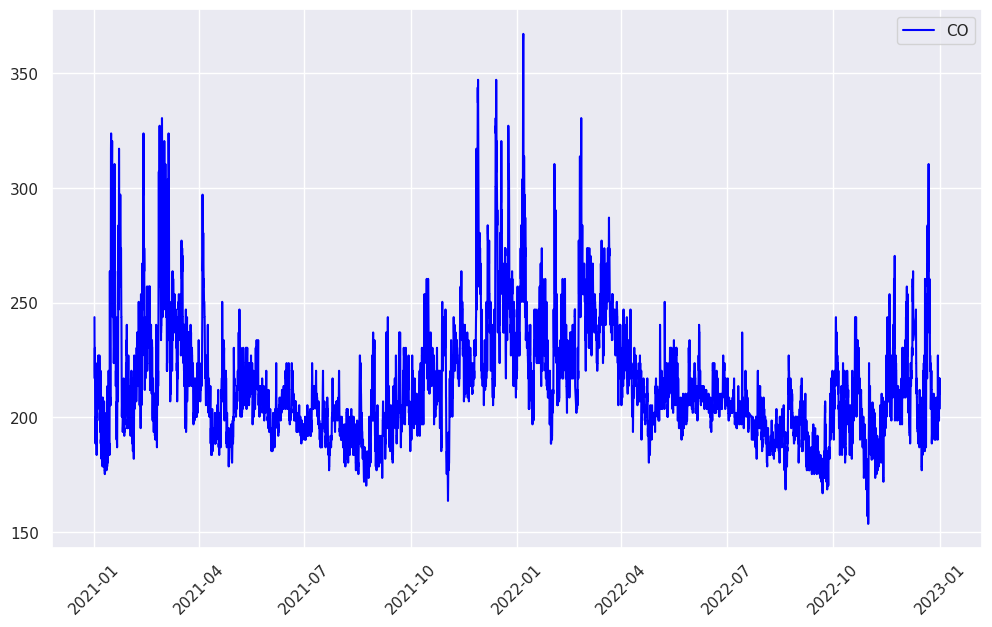

In [6]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
# ax2 = ax.twinx()

ax.plot(air_pol['date_hour'], air_pol['CO'], color = 'blue', label = 'CO')
plt.legend()
plt.xticks(rotation=45);

<Figure size 1200x700 with 0 Axes>

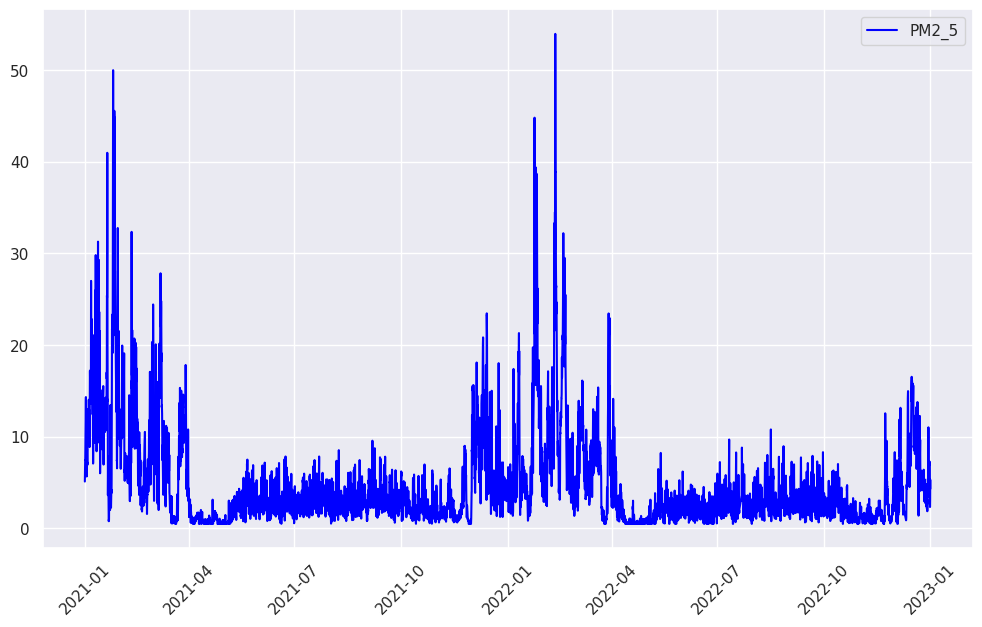

In [7]:
plt.figure(figsize=(12, 7))
fig, ax = plt.subplots(figsize=(12, 7))
# ax2 = ax.twinx()

ax.plot(air_pol['date_hour'], air_pol['PM2_5'], color = 'blue', label = 'PM2_5')
plt.legend()
plt.xticks(rotation=45);

In [8]:
air_plot_train = air_pol[air_pol['date_hour']<='2022-06-30 23:00:0']
air_plot_val = air_pol[air_pol['date_hour'].between('2022-06-30 23:00:0','2022-09-30 23:00:0')]
air_plot_test = air_pol[air_pol['date_hour']>'2022-09-30 23:00:0']

air_plot_train.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)
air_plot_val.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)
air_plot_test.drop(['lon','lat','city','aqi','year_x','year_y', 'date', 'rain_1h', 'visibility', 'month'], axis = 1, inplace = True)

air_plot_train.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']
air_plot_val.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']
air_plot_test.columns = ['CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3','date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point']


air_plot_train.head(3)

,CO,NO,NO2,O3,SO2,PM2_5,PM10,NH3,date,temp,feels_like,pressure,humidity,wind_speed,dew_point
0,243.66,0.0,0.07,41.84,0.07,5.12,11.97,0.41,2021-01-01 00:00:00,9.11,8.43,1007.0,71.0,1.7,4.14
1,233.65,0.0,0.08,44.35,0.07,5.52,14.40,0.38,2021-01-01 01:00:00,8.46,7.31,1006.0,73.0,2.1,3.91
2,226.97,0.0,0.08,46.49,0.06,5.83,16.02,0.34,2021-01-01 02:00:00,8.14,6.94,1006.0,75.0,2.1,3.98


In [9]:
air_pol.columns

Index(['lon', 'lat', 'CO', 'NO', 'NO2', 'O3', 'SO2', 'PM2_5', 'PM10', 'NH3',
       'aqi', 'year_x', 'city', 'date_hour', 'date', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'dew_point', 'visibility',
       'rain_1h', 'year_y', 'month'],
      dtype='object')

In [10]:
# Importa las bibliotecas necesarias
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Divide el conjunto de datos en columnas temporales y numéricas
temporal_columns = ['date']
numeric_columns = [col for col in air_plot_train.columns if col not in temporal_columns]

# Procesa las columnas temporales en todos los conjuntos de datos
for air_pol in [air_plot_train, air_plot_val, air_plot_test]:
    air_pol['date'] = pd.to_datetime(air_pol['date'])  # Convierte la columna 'date' a tipo de datos DateTime

# Normaliza las columnas numéricas en todos los conjuntos de datos
scaler = StandardScaler()
for air_pol in [air_plot_train, air_plot_val, air_plot_test]:
    air_pol[numeric_columns] = scaler.fit_transform(air_pol[numeric_columns])

# Asegúrate de que todas las columnas sean numéricas y no haya columnas temporales en los conjuntos de validación y prueba
air_plot_train = air_plot_train[numeric_columns]
air_plot_val = air_plot_val[numeric_columns]
air_plot_test = air_plot_test[numeric_columns]

In [11]:
import numpy as np

def create_sequences(data, sequence_length=10):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length:i+sequence_length+1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length
sequence_length = 30

# Prepare sequences for training, validation, and test sets
train_sequences, train_targets = create_sequences(air_plot_train, sequence_length)
val_sequences, val_targets = create_sequences(air_plot_val, sequence_length)
test_sequences, test_targets = create_sequences(air_plot_test, sequence_length)

train_sequences = train_sequences.astype('float32')
train_targets = train_targets.astype('float32')
val_sequences = val_sequences.astype('float32')
val_targets = val_targets.astype('float32')
test_sequences = test_sequences.astype('float32')
test_targets = test_targets.astype('float32')

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(30, activation='tanh', input_shape=(train_sequences.shape[1], train_sequences.shape[-1])))
model.add(Dense(1))  # Output layer with 1 unit for regression

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                5400      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 5431 (21.21 KB)
Trainable params: 5431 (21.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MAE'])

In [15]:
history = model.fit(train_sequences, train_targets, epochs=10, validation_data=(val_sequences, val_targets), batch_size=32)

Epoch 1/10
407/407 [==============================] - 11s 20ms/step - loss: 1.0043 - MAE: 0.7567 - val_loss: 0.9952 - val_MAE: 0.7783
Epoch 2/10
407/407 [==============================] - 6s 14ms/step - loss: 0.9999 - MAE: 0.7550 - val_loss: 0.9965 - val_MAE: 0.7783
Epoch 3/10
407/407 [==============================] - 10s 24ms/step - loss: 0.9997 - MAE: 0.7550 - val_loss: 0.9942 - val_MAE: 0.7767
Epoch 4/10
407/407 [==============================] - 6s 14ms/step - loss: 0.9996 - MAE: 0.7551 - val_loss: 0.9952 - val_MAE: 0.7761
Epoch 5/10
407/407 [==============================] - 7s 18ms/step - loss: 0.9995 - MAE: 0.7547 - val_loss: 0.9952 - val_MAE: 0.7778
Epoch 6/10
407/407 [==============================] - 7s 17ms/step - loss: 0.9993 - MAE: 0.7549 - val_loss: 0.9838 - val_MAE: 0.7727
Epoch 7/10
407/407 [==============================] - 6s 14ms/step - loss: 0.9994 - MAE: 0.7547 - val_loss: 0.9896 - val_MAE: 0.7765
Epoch 8/10
407/407 [==============================] - 9s 21ms/step 

In [16]:
ypred_shape = model.predict(test_sequences)

_, mae_tr= model.evaluate(train_sequences, train_targets)
_, mae_ts= model.evaluate(val_sequences, val_targets)
print('MAE train: %.2f' % (mae_tr))
print('MAE test: %.2f' % (mae_ts))

67/67 [==============================] - 0s 6ms/step - loss: 0.9895 - MAE: 0.7751
MAE train: 0.75
MAE test: 0.78


## Validation plots

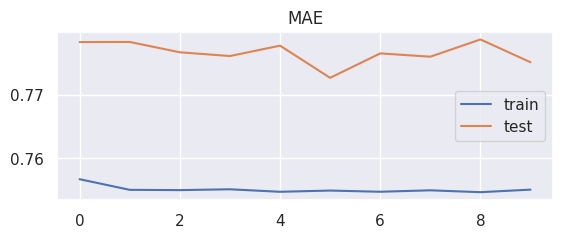

In [17]:
plt.subplot(211)
plt.title('MAE')
plt.plot(history.history['MAE'], label='train')
plt.plot(history.history['val_MAE'], label='test')
plt.legend()

### Using only CO as predictive

In [18]:
 y_CO_train = air_plot_train[['CO']]
y_CO_val = air_plot_val[['CO']]
y_CO_test = air_plot_test[['CO']]

In [29]:
y_CO_train

,CO
0,0.987598
1,0.594696
2,0.332499
3,0.201794
4,0.070695
...,...
13026,-0.453305
13027,-0.387756
13028,-0.387756
13029,-0.453305


In [19]:
# Prepare sequences for training, validation, and test sets
train_sequences, train_targets = create_sequences(y_CO_train, sequence_length)
val_sequences, val_targets = create_sequences(y_CO_val, sequence_length)
test_sequences, test_targets = create_sequences(y_CO_test, sequence_length)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(30, activation='tanh', input_shape=(train_sequences.shape[1], train_sequences.shape[-1])))
model.add(Dense(1))  # Output layer with 1 unit for regression

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30)                3840      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3871 (15.12 KB)
Trainable params: 3871 (15.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MAE'])

In [23]:
history = model.fit(train_sequences, train_targets, epochs=10, validation_data=(val_sequences, val_targets), batch_size=32)

Epoch 1/10
407/407 [==============================] - 9s 18ms/step - loss: 0.1143 - MAE: 0.2105 - val_loss: 0.0555 - val_MAE: 0.1698
Epoch 2/10
407/407 [==============================] - 7s 17ms/step - loss: 0.0274 - MAE: 0.1067 - val_loss: 0.0330 - val_MAE: 0.1287
Epoch 3/10
407/407 [==============================] - 6s 14ms/step - loss: 0.0200 - MAE: 0.0914 - val_loss: 0.0284 - val_MAE: 0.1205
Epoch 4/10
407/407 [==============================] - 8s 19ms/step - loss: 0.0171 - MAE: 0.0851 - val_loss: 0.0257 - val_MAE: 0.1165
Epoch 5/10
407/407 [==============================] - 6s 15ms/step - loss: 0.0159 - MAE: 0.0837 - val_loss: 0.0247 - val_MAE: 0.1139
Epoch 6/10
407/407 [==============================] - 6s 14ms/step - loss: 0.0156 - MAE: 0.0836 - val_loss: 0.0246 - val_MAE: 0.1162
Epoch 7/10
407/407 [==============================] - 8s 20ms/step - loss: 0.0156 - MAE: 0.0843 - val_loss: 0.0246 - val_MAE: 0.1151
Epoch 8/10
407/407 [==============================] - 6s 16ms/step - 

In [24]:
ypred_shape = model.predict(test_sequences)

_, mae_tr= model.evaluate(train_sequences, train_targets)
_, mae_ts= model.evaluate(val_sequences, val_targets)
print('MAE train: %.2f' % (mae_tr))
print('MAE test: %.2f' % (mae_ts))

67/67 [==============================] - 0s 5ms/step - loss: 0.0249 - MAE: 0.1155
MAE train: 0.08
MAE test: 0.12


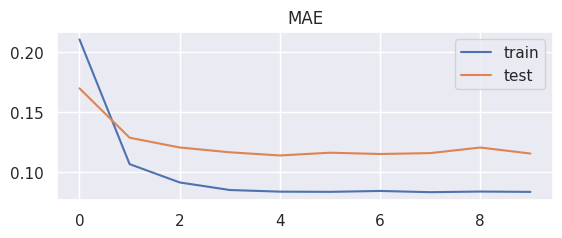

In [25]:
plt.subplot(211)
plt.title('MAE')
plt.plot(history.history['MAE'], label='train')
plt.plot(history.history['val_MAE'], label='test')
plt.legend()

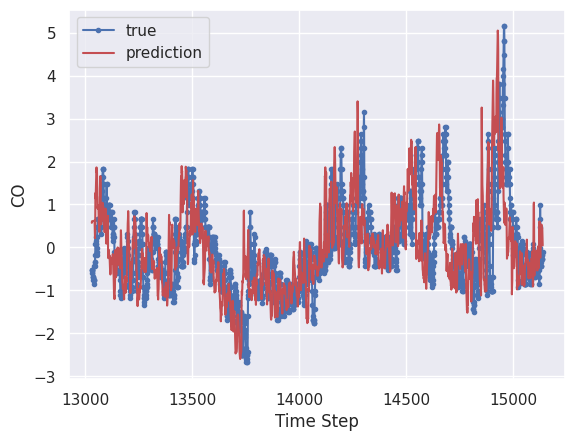

In [26]:
#plt.plot(np.arange(0, len(y_CO_train_shape)), y_CO_train_shape.flatten(), 'g', label="history")
# Nos aseguramos de que y_CO_test y ypred_shape tengan la misma longitud
length = min(len(y_CO_test), len(ypred_shape))
y_CO_test = y_CO_test[:length]
ypred_shape = ypred_shape[:length]

plt.plot(np.arange(len(y_CO_train.values), len(y_CO_train.values) + len(y_CO_test.values)), y_CO_test.values.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_CO_train.values), len(y_CO_train.values) + len(y_CO_test.values)), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('CO')
plt.xlabel('Time Step')
plt.legend()
plt.show();

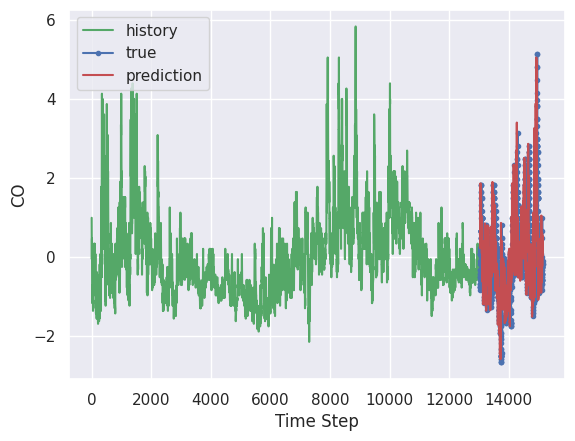

In [27]:
plt.plot(np.arange(0, len(y_CO_train.values)), y_CO_train.values.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_CO_train.values), len(y_CO_train.values) + len(y_CO_test.values)), y_CO_test.values.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_CO_train.values), len(y_CO_train.values) + len(y_CO_test.values)), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('CO')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Conclusión

Fijándonos en el MAE, vemos que utilizando únicamente la columna de 'CO', el valor de MAE se reduce mucho, de 0.77 a 0.11, además las gráficas son muy buenas.